In [1]:
import json
import os

import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch

In [2]:
import sys

sys.path.append(os.path.abspath('../'))

In [11]:
experiments = [
    'gat_x1',
    'gatv2_x1',
    'bert_x1',
    'roberta_x1',
    'roberta_x1_lr3.5',
    'twitter_roberta_x1',
    'twitter_roberta_x1_lr3.5',
    'joint_x1',
    # 'joint_roberta_x1',
    'joint_roberta_x1_lr3.5',
    # 'joint_twitter_roberta_x1',
    'joint_twitter_roberta_x1_lr3.5',
    'jointv2_x1',
    # 'jointv2_roberta_x1',
    'jointv2_roberta_x1_lr3.5',
    'jointv2_twitter_roberta_x1_lr3.5',
    'jointv2_twitter_roberta_x1_lr1',
    'joint_x10',
    'jointv2_twitter_roberta_x10_lr1'
]

labels = [
    'GAT',
    'GATv2',
    'BERT',
    'RoBERTa (lr=5e-5)',
    'RoBERTa (lr=3.5e-5)',
    'RoBERTa-RT (lr=5e-5)',
    'RoBERTa-RT (lr=3.5e-5)',
    'GAT+Bert',
    # 'GAT+RoBERTa\n (lr=5.5e-5)',
    'GAT+RoBERTa\n (lr=3.5e-5)',
    # 'GAT+TwitterRoBERTa\n (lr=5.5e-5)',
    'GAT+RoBERTa-RT\n (lr=3.5e-5)',
    'GATv2+BERT',
    # 'GATv2+RoBERTa\n (lr=5e-5)',
    'GATv2+RoBERTa\n (lr=3.5e-5)',
    'GATv2+RoBERTa-RT\n (lr=3.5e-5)',
    'GATv2+RoBERTa-RT\n (lr=1e-5)',
    'GAT+BERT',
    'GATv2+RoBERTa-RT\n (lr=1e-5)'
]

assert (len(experiments) == len(labels))

baseline = {'filename': 'joint_x10', 'name': 'GAT+BERT'}
final_results = {'filename': 'jointv2_twitter_roberta_x10_lr1', 'name': 'GATv2+TwitterRoBERTa\n (lr=1e-5)'}

## Plotting for training and test metrics

In [12]:
data_x1 = []
data_x10 = []

for _, experiment in enumerate(experiments):
    print(f"Pulling data for experiment {experiment}...")
    file_path = f"../results/{experiment}_metrics.json"
    f = open(file_path)
    data = json.load(f)
    f.close()
    data = [*data.values()]
    if len(data) == 1:
        d_x1 = data[0]
        # print(data)
        d_x1 = {k: v for k, v in d_x1.items() if type(v) is list and len(v) > 0}
        data_x1.append(pd.DataFrame.from_dict(d_x1))
    else:
        d_x10 = [{k: v for k, v in d.items() if type(v) is list and len(v) > 0} for d in data]
        data_x10.append([pd.DataFrame.from_dict(d) for d in d_x10])
print(len(data_x1))
print(len(data_x10))

Pulling data for experiment gat_x1...
Pulling data for experiment gatv2_x1...
Pulling data for experiment bert_x1...
Pulling data for experiment roberta_x1...
Pulling data for experiment roberta_x1_lr3.5...
Pulling data for experiment twitter_roberta_x1...
Pulling data for experiment twitter_roberta_x1_lr3.5...
Pulling data for experiment joint_x1...
Pulling data for experiment joint_roberta_x1_lr3.5...
Pulling data for experiment joint_twitter_roberta_x1_lr3.5...
Pulling data for experiment jointv2_x1...
Pulling data for experiment jointv2_roberta_x1_lr3.5...
Pulling data for experiment jointv2_twitter_roberta_x1_lr3.5...
Pulling data for experiment jointv2_twitter_roberta_x1_lr1...
Pulling data for experiment joint_x10...
Pulling data for experiment jointv2_twitter_roberta_x10_lr1...
14
2


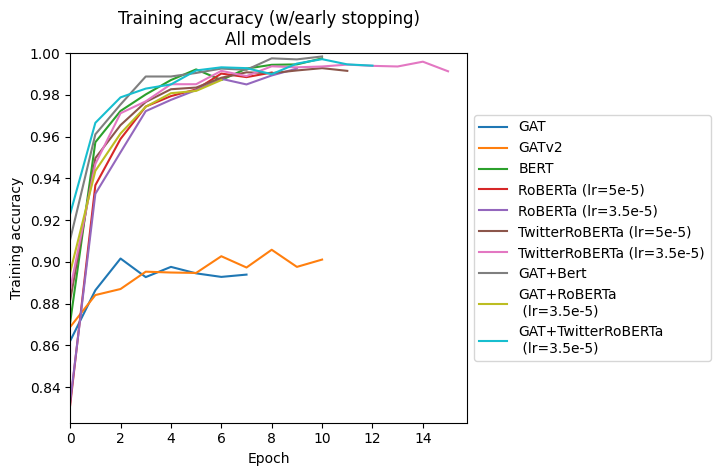

In [30]:
fig = plt.figure()
ax = plt.subplot(111)

sample = experiments[0:10]

for idx, experiment in enumerate(sample):
    d = data_x1[0:10][idx].train_acc
    ax.plot(d, label=labels[0:10][idx])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Epoch')
ax.set_xlim(0.0)
ax.set_ylabel('Training accuracy')
ax.set_ylim(top=1.0)
ax.set_title("Training accuracy (w/early stopping)\nAll models")

plt.savefig("../publish/images/training_acc_all.png", dpi=300)
plt.show()

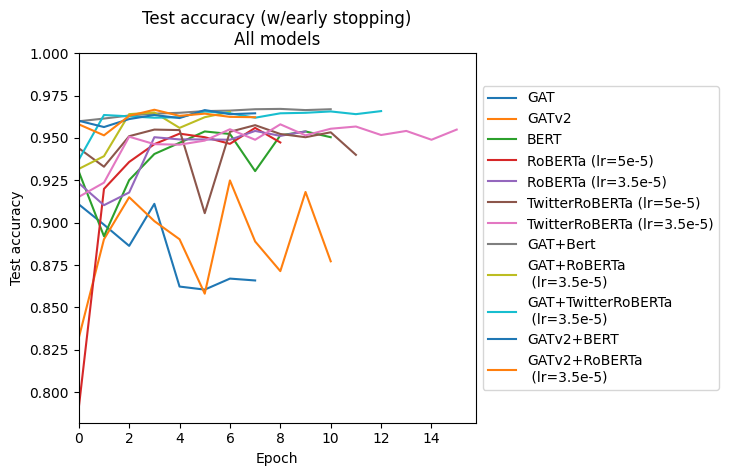

In [125]:
fig = plt.figure()
ax = plt.subplot(111)

sample = experiments[0:12]

for idx, experiment in enumerate(sample):
    d = data_x1[0:12][idx].test_acc
    ax.plot(d, label=labels[0:12][idx])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Epoch')
ax.set_xlim(0.0)
ax.set_ylabel('Test accuracy')
ax.set_ylim(top=1.0)
ax.set_title("Test accuracy (w/early stopping)\nAll models")

plt.savefig("../publish/images/test_acc_all.png", dpi=300)
plt.show()

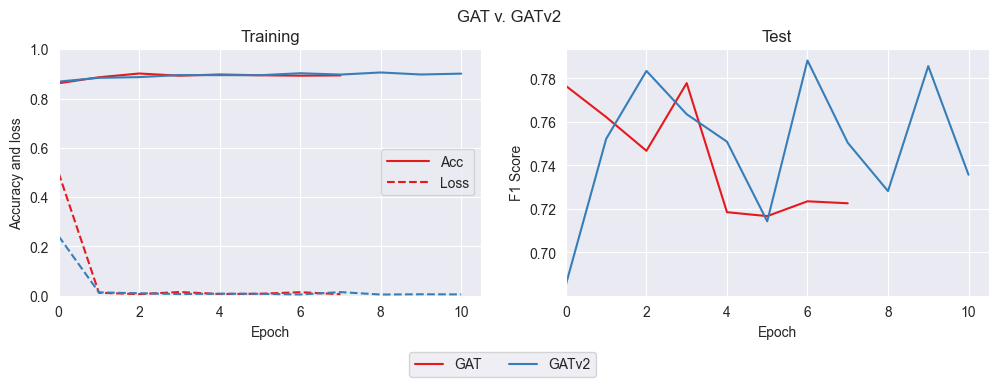

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sample = experiments[0:2]

cmap = plt.get_cmap('Set1')
for idx, experiment in enumerate(sample):
    d = data_x1[0:2][idx]
    train_acc = d.train_acc
    ax1.plot(train_acc, color=cmap(idx))
    loss = d.train_loss
    ax1.plot(loss, color=cmap(idx), linestyle='dashed')
    # test_acc = d.test_acc
    # ax2.plot(test_acc, label=f"{labels[0:2][idx]} acc")
    f1 = d.test_f1
    ax2.plot(f1, color=cmap(idx), label=f"{labels[0:2][idx]}")

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
ax2.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.2), ncol=2)
ax1.legend(["Acc", "Loss"], loc="center right", handlelength=3)
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_xlim(0.0)
ax2.set_xlim(0.0)
ax1.set_ylabel('Accuracy and loss')
ax2.set_ylabel('F1 Score')
ax1.set_ylim(0.0, 1.0)
# ax2.set_ylim(top=1.0)
ax1.set_title("Training")
ax2.set_title("Test")
plt.suptitle("GAT v. GATv2")

plt.savefig("../publish/images/gat_v_gatv2.png", dpi=300)
plt.show()

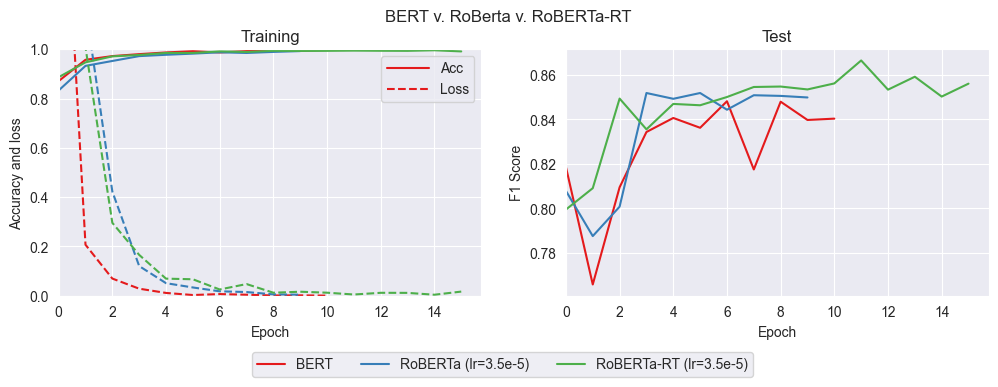

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sample = experiments[2:7:2]

for idx, experiment in enumerate(sample):
    d = data_x1[2:7:2][idx]
    train_acc = d.train_acc
    ax1.plot(train_acc, color=cmap(idx), label=f"{labels[2:7:2][idx]}")
    loss = d.train_loss
    ax1.plot(loss, color=cmap(idx), linestyle='dashed')
    # test_acc = d.test_acc
    # ax2.plot(test_acc, label=f"{labels[2:6][idx]} acc")
    f1 = d.test_f1
    ax2.plot(f1, color=cmap(idx), label=f"{labels[2:7:2][idx]}")

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

ax2.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.2), ncol=5)
ax1.legend(["Acc", "Loss"], handlelength=3)
# ax2.legend(loc='lower right')
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_xlim(0.0)
ax2.set_xlim(0.0)
ax1.set_ylabel('Accuracy and loss')
ax2.set_ylabel('F1 Score')
ax1.set_ylim(0.0, 1.0)
# ax2.set_ylim(top=1.0)
ax1.set_title("Training")
ax2.set_title("Test")
plt.suptitle("BERT v. RoBerta v. RoBERTa-RT")
plt.savefig("../publish/images/all_berts.png", dpi=300)
plt.show()

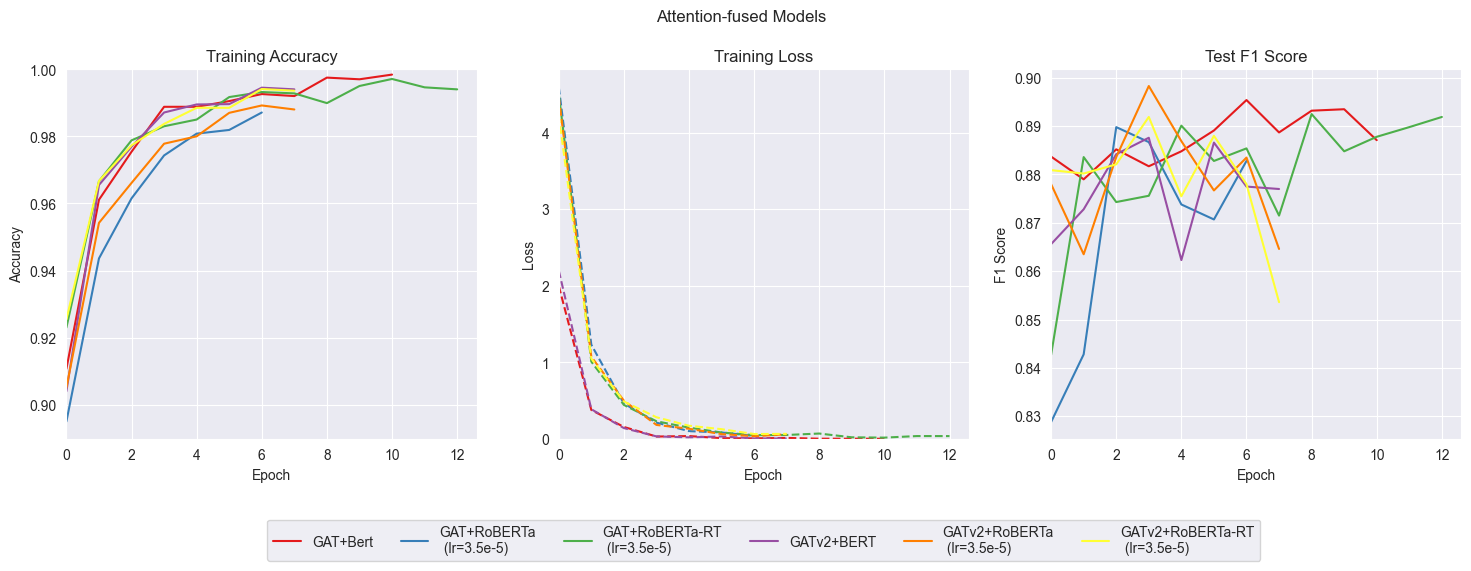

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sample = experiments[7:13]
# sample = experiments[7:10]

for idx, experiment in enumerate(sample):
    d = data_x1[7:13][idx]
    train_acc = d.train_acc

    ax1.plot(train_acc, color=cmap(idx), label=f"{labels[7:13][idx]}")
    loss = d.train_loss
    ax2.plot(loss, color=cmap(idx), linestyle='dashed')
    # test_acc = d.test_acc
    # ax2.plot(test_acc, label=f"{labels[2:6][idx]} acc")
    f1 = d.test_f1
    ax3.plot(f1, color=cmap(idx), label=f"{labels[7:13][idx]}")

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

ax1.legend(loc='upper center', bbox_to_anchor=(1.7, -0.2), ncol=9)
# ax1.legend(["Acc", "Loss"], handlelength=3)
# ax2.legend(loc='lower right')
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax3.set_xlabel('Epoch')

ax1.set_xlim(0.0)
ax2.set_xlim(0.0)
ax3.set_xlim(0.0)

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')
ax3.set_ylabel('F1 Score')
ax1.set_ylim(top=1.0)
ax2.set_ylim(bottom=0.0)
# ax3.set_ylim(top=1.0)

ax1.set_title("Training Accuracy")
ax2.set_title("Training Loss")
ax3.set_title("Test F1 Score")

plt.suptitle("Attention-fused Models")
plt.savefig("../publish/images/all_joint.png", dpi=300)
plt.show()

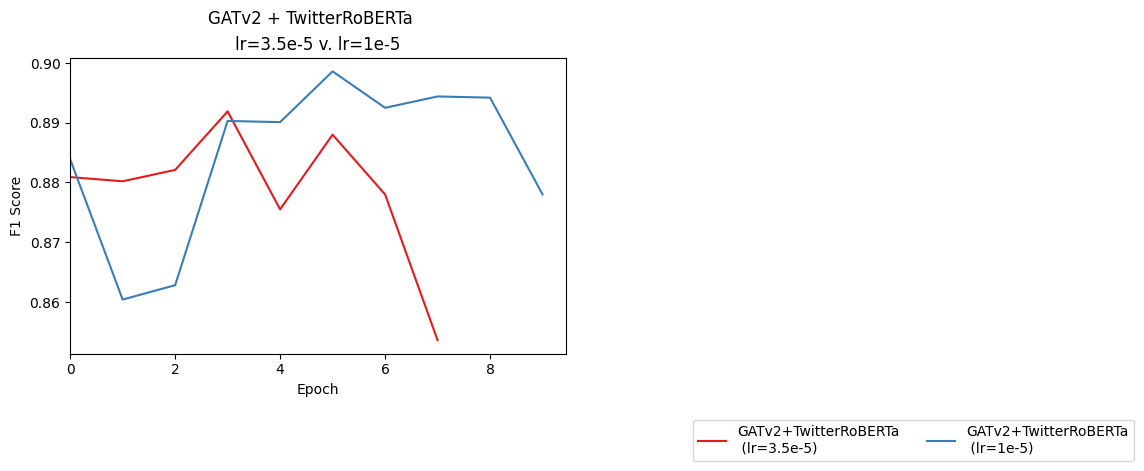

In [56]:
fig = plt.figure()
ax = plt.subplot(111)

sample = experiments[12:14]

for idx, experiment in enumerate(sample):
    d = data_x1[12:14][idx]
    f1 = d.test_f1
    ax.plot(f1, color=cmap(idx), label=f"{labels[12:14][idx]}")

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(1.7, -0.2), ncol=9)
ax.set_xlabel('Epoch')

ax.set_xlim(0.0)
ax.set_ylabel('F1 Score')
# ax.set_ylim(top=1.0)

ax.set_title("lr=3.5e-5 v. lr=1e-5")

plt.suptitle("GATv2 + TwitterRoBERTa")
plt.savefig("../publish/images/gatv2_twitter_roberta_lr_compare.png", dpi=300)
plt.show()

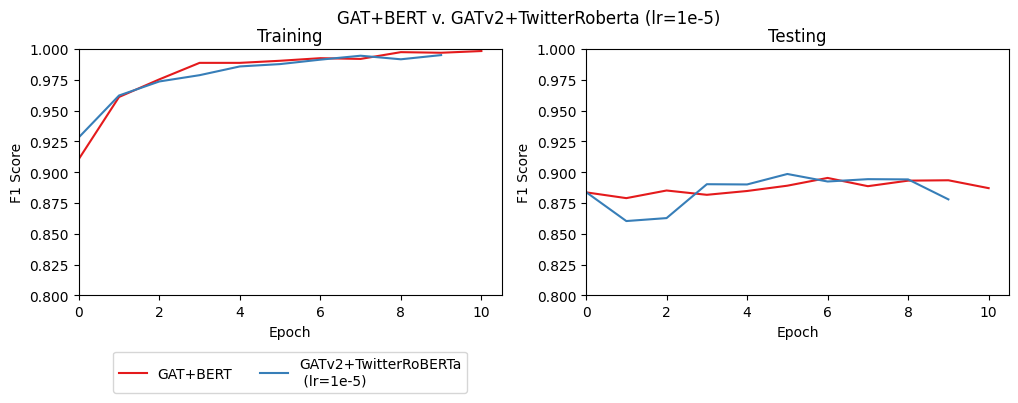

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

d = data_x1[7]
train_f1 = d.train_f1
test_f1 = d.test_f1
ax2.plot(test_f1, color=cmap(0), label=f"{baseline['name']}")
ax1.plot(train_f1, color=cmap(0), label=f"{baseline['name']}")

d = data_x1[13]
train_f1 = d.train_f1
test_f1 = d.test_f1
ax2.plot(test_f1, color=cmap(1), label=f"{final_results['name']}")
ax1.plot(train_f1, color=cmap(1), label=f"{final_results['name']}")

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
ax1.set_xlabel('Epoch')

ax1.set_xlim(0.0)
ax1.set_ylim(0.8, 1.0)
ax1.set_ylabel('F1 Score')
ax1.set_title("Training")

ax2.set_xlim(0.0)
ax2.set_ylim(0.8, 1.0)
ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Epoch')
ax2.set_title("Testing")

plt.suptitle("GAT+BERT v. GATv2+TwitterRoberta (lr=1e-5)")
plt.savefig("../publish/images/baseline_final.png", dpi=300)
plt.show()

Best iteration: 7
Worst iteration: 9
[0.8874, 0.8829222222222222, 0.88116, 0.8652899999999999, 0.8796285714285713, 0.8796, 0.8741, 0.8829466666666665, 0.8818857142857143, 0.877225]
Model: GAT+BERT
		Mean test F1 Score: 0.8927099999999999 / 0.8795669902912621
		Max test F1 Score: 0.9018 / Min max score: 0.8851
		Min test F1 Score: 0.7132
		StDev test F1 Score: 0.004762866783776343 / 0.02036091529190615
Best iteration: 2
Worst iteration: 8
[0.8845199999999999, 0.881818181818182, 0.88207, 0.8806875000000001, 0.8841272727272728, 0.8859312500000001, 0.88185, 0.8781249999999999, 0.8761833333333334, 0.8845]
Model: GATv2+TwitterRoBERTa
 (lr=1e-5)
		Mean test F1 Score: 0.8936299999999999 / 0.8823920792079208
		Max test F1 Score: 0.9012 / Min max score: 0.883
		Min test F1 Score: 0.823
		StDev test F1 Score: 0.004715516938788362 / 0.011356637028090026


Text(0, 0.5, 'F1 Score')

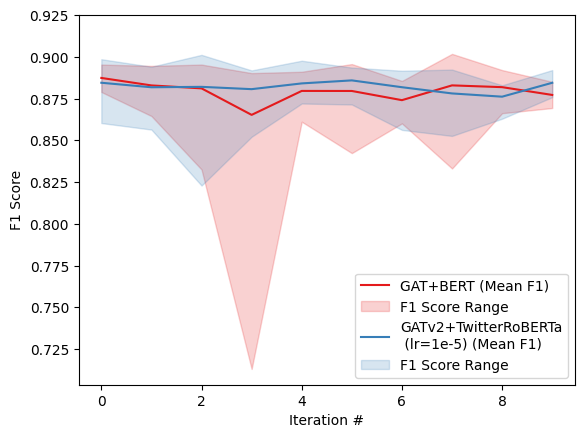

In [112]:
fig = plt.figure()
ax = plt.subplot(111)

for idx, model_res in enumerate(data_x10):
    mean_test_f1 = 0.0
    max_f1 = 0.0
    min_f1 = 1.1
    minmax_f1 = 1.1
    maxes = []
    mins = []
    means = []
    all_f1s = []
    for df in model_res:
        f1 = df['test_f1']
        all_f1s += [*f1]
        _max = f1.max()
        maxes.append(_max)
        _min = f1.min()
        mins.append(_min)
        means.append(f1.mean())
        max_f1 = _max if _max > max_f1 else max_f1
        minmax_f1 = _max if _max < minmax_f1 else minmax_f1
        min_f1 = _min if _min < min_f1 else min_f1
        mean_test_f1 += _max
    max_std = np.std(maxes)
    print(f"Best iteration: {np.argmax(maxes)}")
    print(f"Worst iteration: {np.argmin(maxes)}")

    mean_test_f1 /= 10
    print(means)
    model_name = baseline['name'] if idx == 0 else final_results['name']
    ax.plot(means, color=cmap(idx), label=f"{model_name} (Mean F1)")
    ax.fill_between(np.linspace(0, 9, 10), maxes, mins, color=cmap(idx), alpha=0.2, label=f"F1 Score Range")
    print(f"Model: {model_name}")
    print(f"\t\tMean test F1 Score: {mean_test_f1} / {np.mean(all_f1s)}")
    print(f"\t\tMax test F1 Score: {max_f1} / Min max score: {minmax_f1}")
    print(f"\t\tMin test F1 Score: {min_f1}")
    print(f"\t\tStDev test F1 Score: {max_std} / {np.std(all_f1s)}")

ax.legend(loc="lower right")
ax.set_ylim(top=0.925)
ax.set_xlabel('Iteration #')
ax.set_ylabel('F1 Score')



Text(0.5, 1.0, 'Best iteration for baseline')

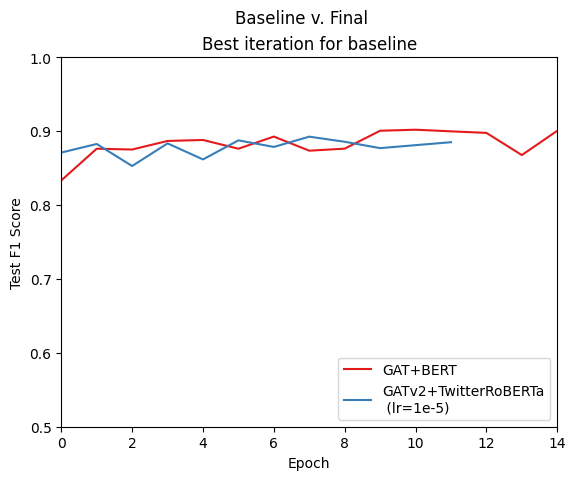

In [122]:
fig = plt.figure()
ax = plt.subplot(111)

best_baseline = data_x10[0][7]
ax.plot(best_baseline['test_f1'], color=cmap(0), label=f"{baseline['name']}")

best_final = data_x10[1][7]
ax.plot(best_final['test_f1'], color=cmap(1), label=f"{final_results['name']}")

ax.legend(loc="lower right")
ax.set_ylim(0.5, 1.0)
ax.set_xlim(0.0, 14.0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test F1 Score')
plt.suptitle("Baseline v. Final")
ax.set_title('Best iteration for baseline')

Text(0.5, 1.0, 'Best iteration for final')

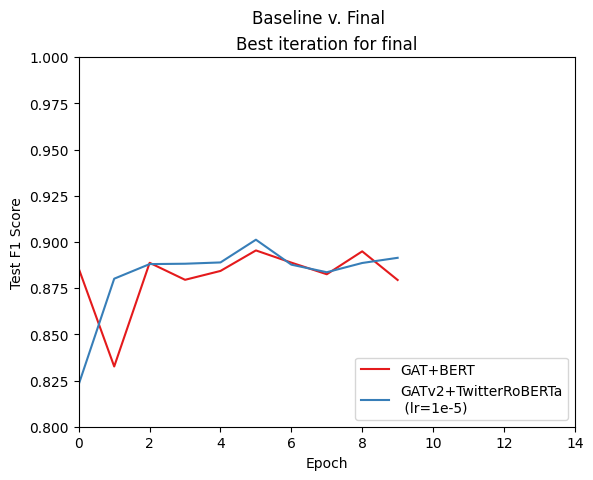

In [123]:
fig = plt.figure()
ax = plt.subplot(111)

best_baseline = data_x10[0][2]
ax.plot(best_baseline['test_f1'], color=cmap(0), label=f"{baseline['name']}")

best_final = data_x10[1][2]
ax.plot(best_final['test_f1'], color=cmap(1), label=f"{final_results['name']}")

ax.legend(loc="lower right")
ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.0, 14.0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test F1 Score')
plt.suptitle("Baseline v. Final")
ax.set_title('Best iteration for final')

## Confusion matrices

In [3]:
! rm -rf cardiffnlp/twitter-roberta-base-offensive

In [4]:
import transformers
from dataloaders.graph_data import load_graph
from models.joint import JOINTv2_TWIT_ROBERTA

final_path = os.path.join('../saved_models', 'jointv2_twitter_roberta_2_best.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(final_path, map_location=device)

tweet_path = '../data/tweets.csv'
user_path = '../data/users.csv'
relationship_path = '../data/relationships.csv'
ts = 0.3
fm = 'soft'
fi = 'non_off'
num_labels = 2
args = dict()
args['hidden_size'] = 768
args['dropout'] = 0.5

g, _, _, _ = load_graph(tweet_path, user_path, relationship_path, test_size=ts, feat_model=fm, feat_init=fi)
g = g.to(device)
features = g.ndata['features']
features_size = features.size()[1]
MODEL = f"cardiffnlp/twitter-roberta-base-offensive"
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
model = JOINTv2_TWIT_ROBERTA(fs=features_size, model_size='base', args=args, num_labels=num_labels)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Graph(num_nodes=1260, num_edges=10137,
      ndata_schemes={'features': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-offensive were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

JOINTv2_TWIT_ROBERTA(
  (gat): GATv2Layer(
    (layer1): GATv2Conv(
      (fc_src): Linear(in_features=2, out_features=6144, bias=True)
      (fc_dst): Linear(in_features=2, out_features=6144, bias=True)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=2, out_features=6144, bias=True)
    )
  )
  (bert): TwitterROBERTALayer(
    (emb): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): Robert

In [5]:
from dataloaders.data import mydata
from dataloaders.datasets import OLDDataset
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

bs = 32

purl_test, token_ids_test, lens_test, mask_test, labels_test = mydata(path=tweet_path,
                                                                      tokenizer=tokenizer,
                                                                      truncate=512,
                                                                      data_type='test', test_size=ts)

datasets = {
    'test': OLDDataset(
        input_ids=token_ids_test,
        lens=lens_test,
        mask=mask_test,
        url=purl_test,
        labels=labels_test,
    )
}

dataloaders = {
    'test': DataLoader(dataset=datasets['test'], batch_size=bs)
}


def eval(model, g, features, device, criterion, bs):
    model.eval()
    dataloader = dataloaders['test']
    y_pred_all = None
    labels_all = None
    loss = 0
    iters_per_epoch = 0
    for inputs, lens, mask, labels, url in tqdm(dataloader, desc='Testing'):
        iters_per_epoch += 1

        if labels_all is None:
            labels_all = labels.numpy()
        else:
            labels_all = np.concatenate((labels_all, labels.numpy()))

        inputs = inputs.to(device=device)
        lens = lens.to(device=device)
        mask = mask.to(device=device)
        labels = labels.to(device=device)

        with torch.set_grad_enabled(False):
            logits = model(inputs, lens, mask, labels, g, features, url, device)
            _loss = criterion(logits, labels)
            y_pred = logits.argmax(dim=1).cpu().numpy()
            y_prob = torch.index_select(F.softmax(logits, dim=1).cpu(), 1, torch.tensor([1])).numpy()
            loss += _loss.item()

            if y_pred_all is None:
                y_pred_all = y_pred
                y_prob_all = y_prob
            else:
                y_pred_all = np.concatenate((y_pred_all, y_pred))
                y_prob_all = np.concatenate((y_prob_all, y_prob))

    loss /= iters_per_epoch
    f1 = f1_score(labels_all, y_pred_all, average='macro')
    accuracy = accuracy_score(labels_all, y_pred_all)
    recall = recall_score(labels_all, y_pred_all, average='macro')
    precision = precision_score(labels_all, y_pred_all, average='macro')

    fpr, tpr, thresholds = roc_curve(labels_all, y_prob_all)

    AUC = auc(fpr, tpr)
    fpr = [float('%.4f' % i) for i in fpr]
    tpr = [float('%.4f' % i) for i in tpr]

    print(f'loss = {loss:.4f}')
    print(f'Macro-accuracy = {accuracy:.4f}')
    print(f'Macro-recall = {recall:.4f}')
    print(f'Macro- precision = {precision:.4f}')
    print(f'Macro-F1 = {f1:.4f}')
    print(f'AUC = {AUC:.4f}')
    return y_pred_all, y_prob_all, labels_all

/run/media/cprimel/Data/cs6953-dl/graph-fusion-old/.venv/lib/python3.10/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/run/media/cprimel/Data/cs6953-dl/graph-fusion-old/.venv/lib/python3.10/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [6]:
from models.modules.focal_loss import FocalLoss

criterion = FocalLoss()
y_pred, y_prob, y_true = eval(model, g, features, device, criterion, bs)

Testing: 100%|██████████| 120/120 [03:06<00:00,  1.56s/it]

loss = 2.2486
Macro-accuracy = 0.9679
Macro-recall = 0.9269
Macro- precision = 0.8790
Macro-F1 = 0.9012
AUC = 0.9405


[97.61024182 87.77429467]


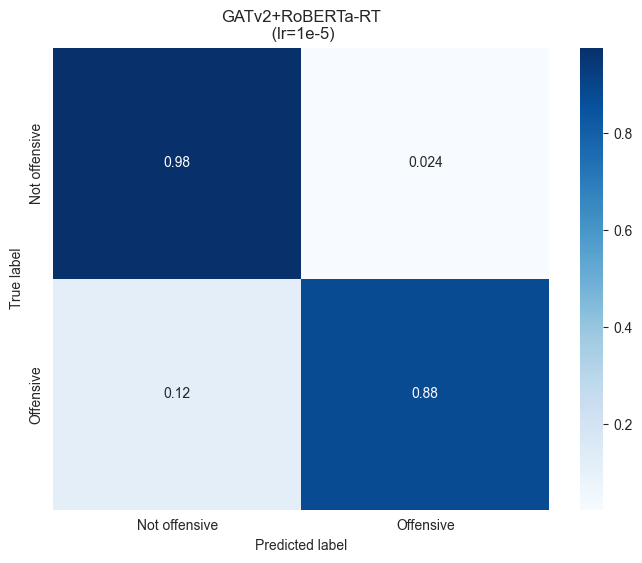

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')
class_accuracy = 100 * cm.diagonal()/cm.sum(1)
print(class_accuracy)

plt.figure(figsize=(8,6))
class_names = ['Not offensive', 'Offensive']

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, cmap='Blues', annot=True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('GATv2+RoBERTa-RT\n (lr=1e-5)')
plt.savefig("../publish/images/cm_final.png", dpi=300)
plt.show()

In [8]:
from models.joint import JOINT
from transformers import BertTokenizer

args['hidden_dropout'] = 0.1
args['attention_dropout'] = 0.1

final_path = os.path.join('../saved_models', 'joint_0_best.pt')
checkpoint = torch.load(final_path, map_location=device)

model = JOINT(fs=features_size, model_size='base', args=args, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(f'bert-base-uncased')

bs = 64

purl_test, token_ids_test, lens_test, mask_test, labels_test = mydata(path=tweet_path,
                                                                      tokenizer=tokenizer,
                                                                      truncate=512,
                                                                      data_type='test', test_size=ts)

datasets = {
    'test': OLDDataset(
        input_ids=token_ids_test,
        lens=lens_test,
        mask=mask_test,
        url=purl_test,
        labels=labels_test,
    )
}

dataloaders = {
    'test': DataLoader(dataset=datasets['test'], batch_size=bs)
}



model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


JOINT(
  (gat): GATLayer(
    (layer1): GATConv(
      (fc): Linear(in_features=2, out_features=6144, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res_fc): Linear(in_features=2, out_features=768, bias=False)
    )
  )
  (bert): BERTLayer(
    (emb): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): L

In [9]:
y_pred, y_prob, y_true = eval(model, g, features, device, criterion,bs)

Testing: 100%|██████████| 60/60 [01:10<00:00,  1.18s/it]

loss = 0.3056
Macro-accuracy = 0.9661
Macro-recall = 0.9202
Macro- precision = 0.8740
Macro-F1 = 0.8954
AUC = 0.9782


[97.52489331 86.52037618]


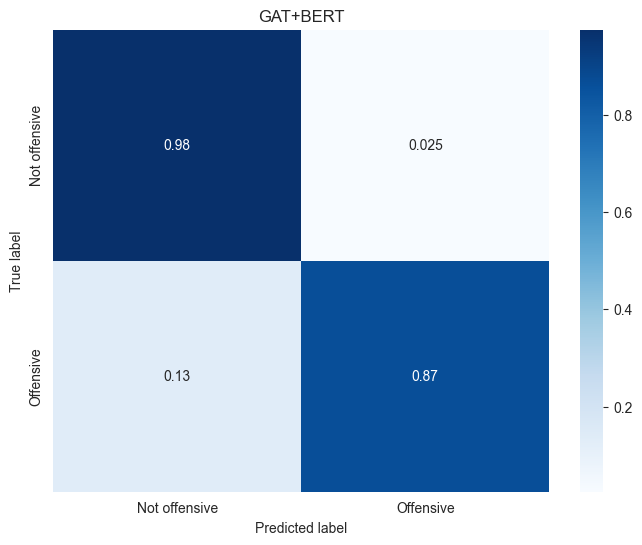

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')
class_accuracy = 100 * cm.diagonal()/cm.sum(1)
print(class_accuracy)

plt.figure(figsize=(8,6))
class_names = ['Not offensive', 'Offensive']

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, cmap='Blues', annot=True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('GAT+BERT')
plt.savefig("../publish/images/cm_baseline.png", dpi=300)
plt.show()

## Graph Attention Heatmap

```
    def attention_per_edge(self, example):
        logits, (edge_index, alpha) = self.forward(example, return_attention_weights=True)
        _, pred = logits.max(dim=1)

        return pred, alpha.cpu().detach().numpy(), edge_index.cpu().detach().numpy()
```

Code based on https://github.com/tech-srl/how_attentive_are_gats/blob/main/dictionary_lookup/experiment.py

In [51]:
from dataloaders.graph_data import load_graph
from models.joint import GATV2

gatv2_path = os.path.join('../saved_models', 'gatv2_0_best.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(gatv2_path, map_location=device)

tweet_path = '../data/tweets.csv'
user_path = '../data/users.csv'
relationship_path = '../data/relationships.csv'
ts = 0.3
fm = 'soft'
fi = 'non_off'
num_labels = 2
args = dict()
args['hidden_size'] = 768

g, _, _, _ = load_graph(tweet_path, user_path, relationship_path, test_size=ts, feat_model=fm, feat_init=fi)
g = g.to(device)
features = g.ndata['features']
features_size = features.size()[1]
model = GATV2(fs=features_size, model_size=None, args=args, num_labels=num_labels)

model.load_state_dict(checkpoint['model_state_dict'])

Graph(num_nodes=1260, num_edges=10137,
      ndata_schemes={'features': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


<All keys matched successfully>

In [68]:
print(model)

GATV2(
  (gat): GATv2Layer(
    (layer1): GATv2Conv(
      (fc_src): Linear(in_features=2, out_features=6144, bias=True)
      (fc_dst): Linear(in_features=2, out_features=6144, bias=True)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=2, out_features=6144, bias=True)
    )
  )
  (layer_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (slf_attn): MultiHeadAttention(
    (w_qs): Linear(in_features=768, out_features=512, bias=False)
    (w_ks): Linear(in_features=768, out_features=512, bias=False)
    (w_vs): Linear(in_features=768, out_features=512, bias=False)
    (fc): Linear(in_features=512, out_features=768, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  )
 

In [88]:
model.slf_attn.w_qs

Linear(in_features=768, out_features=512, bias=False)

In [91]:
def visualize_graph(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'), node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)


/run/media/cprimel/Data/cs6953-dl/graph-fusion-old/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


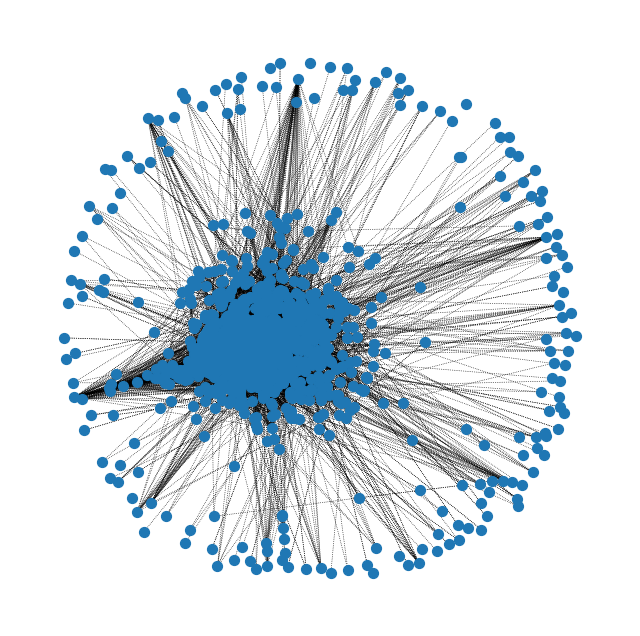

In [99]:
g = dgl.remove_self_loop(g)

nx_g = g.cpu().to_networkx()

visualize_graph(None, nx_g)

In [100]:
g.edata

{}